## Covid-19 CT Scan Classification
---

## Project Objectives:
#### 1. A) Data Preprocessing: Loading data in train and test with labels according to folders. Setting a fix shape for image data. Some preprocess such as normalization, etc.. Flatten in order to use them on our model.
#### 1. B) Model Initialization: SVM and Logistic regression. Loading and setting parameters. 
#### 1. C) Training our models: Measuring elapced time during the fitting process.
#### 1. D) Testing our models: Evaluate and report performance metrics.
#### 2. Using dimentionality reduction and see how the performance will change on our models.
#### 3. CNN Transfer Learning
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler

### 1. A) Data Preprocessing: Loading data in train and test with labels according to folders. Setting a fix shape for image data. Some preprocess such as normalization, etc.. Flatten in order to use them on our model.

#### Here we implement a function for reading, resizing, and normalizing our data. As it is nothing special with this and it is a simple imread, resize and normalization I used the same function that is available all over the internet.
#### I chose 256 x 256 as a fixed size to resize all of our data because they were originally about this size and also I like everything to be in power of 2.

In [ ]:
''' 
A function for loading and normalizing images
Copied from: medium.com
'''

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Reading the image with grayscale mode
    img = cv2.resize(img, (256, 256))                 # Resizing
    img = np.array(img, dtype='float32')              # Convert its datatype to float so we can have a number between 0 and 1
    img = img/255                                     # Normalization (Range of 0 and 1)
    return img

### labels:
> #### 0 - Covid
> #### 1 - Viral Pneumonia
> #### 2 - Normal

In [ ]:
X_train = [] # To store train images
y_train = [] # To store train labels

train_path = "/content/drive/MyDrive/Covid19-dataset/train/" # path containing training image samples

#### This block is the most known lines of code which does the effort of reading folders in our data and uses os library to read files and adding them to the list we initiated to store images data (calls read_and_preprocess function) and also uses the first char in the name of folders to organize a list of labels in the list we initiate for that earlier.

In [ ]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

Then I converted our lists to numpy array as it is the most correct way to store data and passing them to ML models.

In [ ]:
X_train = np.array(X_train)
print(X_train.shape)
y_train = np.array(y_train)
print(y_train.shape)

(251, 256, 256)
(251,)



## We have more number of covid samples that Pneumonia and Normal

<BarContainer object of 3 artists>

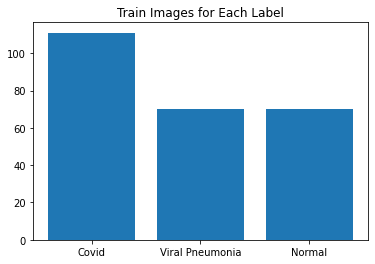

In [ ]:
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])


### Visualizing some random samle to see what is going on in our data.


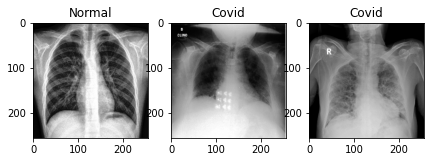

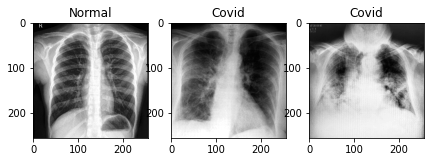

In [ ]:
import random

title = {0:"Covid", 1:"Viral Pneumonia", 2:"Normal"}

rows = 2
columns = 3

for i in range(2):
    
    fig = plt.figure(figsize=(7,7))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos], cmap='gray')
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+pneumonia_count)
    plt.imshow(X_train[pos], cmap='gray')
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 3)
    pos = random.randint(covid_count+pneumonia_count, covid_count+pneumonia_count+normal_count)
    plt.imshow(X_train[pos], cmap='gray')
    plt.title(title[y_train[pos]])

### As our data is too small I did a little bit of augmentation which it is a simple horizontal flip.

In [ ]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])           # The actual fliping line
    X_aug.append(X_new)
    y_aug.append(y_train[i])

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
print(X_train.shape)

y_train = np.append(y_train, y_aug, axis=0)
print(y_train.shape)

(502, 256, 256)
(502,)


### Did all those loading and preprocessing steps on test data, as well.
### Except data augmentation because I feel it is kind of not so wise thing to apply data augmentation to test data.

In [ ]:
X_test = [] # To store validation and test images
y_test = [] # To store validation and test labels

val_path = '/content/drive/MyDrive/Covid19-dataset/test/'

for folder in os.scandir(val_path):
    for entry in os.scandir(val_path + folder.name):

        X_test.append(read_and_preprocess(val_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='V':
            y_test.append(1)
        else:
            y_test.append(2)
            
X_test = np.array(X_test)
y_test = np.array(y_test)

(66, 256, 256)


<BarContainer object of 3 artists>

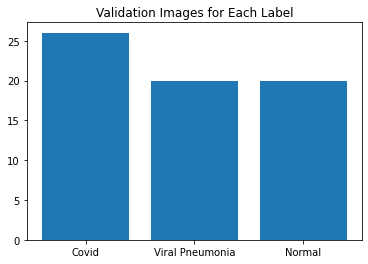

In [ ]:
print(X_test.shape) # We have 66 images for validation and testing

covid_count = len(y_test[y_test==0])
pneumonia_count = len(y_test[y_test==1])
normal_count = len(y_test[y_test==2])

plt.title("Validation Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more number of covid samples that Pneumonia and Normal in test dataset as well

In [ ]:
X_train = X_train.flatten().reshape(502,65536)
print(X_train.shape)
X_test = X_test.flatten().reshape(66,65536)
print(X_test.shape)

(502, 65536)
(66, 65536)


### 1. B) Model Initialization: SVM and Logistic regression. Loading and setting parameters. 
### 1. C) Training our models: Measuring elapced time during the fitting process.
### 1. D) Testing our models: Evaluate and report performance metrics.

> #### I've used random search to find best parameters on both SVM and Logistic Regression.
> #### For SVM the search done for C value uniform of 2 with 10, gamma value with 0.1 and 1, and for kernel did a grid search on rbf, poly and linear.
> #### For Logistic Regression for C value used uniform of 0 with 4 and grid search on the regularization of L1 and L2 also known as ridge and lasso.

In [ ]:
mySVM = SVC(gamma='auto', random_state=44)
rand_list = {"C": uniform(2, 10),
             "gamma": uniform(0.1, 1),
             "kernel": ['linear', 'poly', 'rbf']}

SVM_search = RandomizedSearchCV(mySVM, param_distributions = rand_list, n_iter = 10, cv = 3, verbose=3, random_state=44)

In [ ]:
SVM_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=10.348421486656495, gamma=0.20479610436986975, kernel=linear;, score=0.917 total time=   3.4s
[CV 2/3] END C=10.348421486656495, gamma=0.20479610436986975, kernel=linear;, score=0.934 total time=   5.1s
[CV 3/3] END C=10.348421486656495, gamma=0.20479610436986975, kernel=linear;, score=0.940 total time=   3.2s
[CV 1/3] END C=3.8441869586192694, gamma=0.3963759273978946, kernel=linear;, score=0.917 total time=   3.2s
[CV 2/3] END C=3.8441869586192694, gamma=0.3963759273978946, kernel=linear;, score=0.934 total time=   3.2s
[CV 3/3] END C=3.8441869586192694, gamma=0.3963759273978946, kernel=linear;, score=0.940 total time=   3.2s
[CV 1/3] END C=5.937795510882514, gamma=0.5090726098608986, kernel=rbf;, score=0.440 total time=  16.5s
[CV 2/3] END C=5.937795510882514, gamma=0.5090726098608986, kernel=rbf;, score=0.443 total time=  16.2s
[CV 3/3] END C=5.937795510882514, gamma=0.5090726098608986, kernel=rbf;, score=0

RandomizedSearchCV(cv=3, estimator=SVC(gamma='auto', random_state=44),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc1cd55a2d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc1cd55a150>,
                                        'kernel': ['linear', 'poly', 'rbf']},
                   random_state=44, verbose=3)

> ## Result shows that the best model found with the C value: 8.315, gamma: 0.89 and poly kernel with the accuracy: 0.92 which is considerebly good.
> ## As it is shown in the table above the fiting process got around 3.2 seconds to run.
> ## Other fiting times are also listed above as we can see rbf kernel is way more slower than others with around 17 seconds.

In [ ]:
print(SVM_search.best_params_)

{'C': 8.31521012310841, 'gamma': 0.8986246602807306, 'kernel': 'poly'}


In [ ]:
SVM_preds = SVM_search.predict(X_test)

SVM_accuracy = accuracy_score(y_test, SVM_preds)
print("Best accuracy on SVM :", SVM_accuracy)

Best accuracy on SVM : 0.9242424242424242


### Best found hyperparameters on SVM model Confusion matrix:

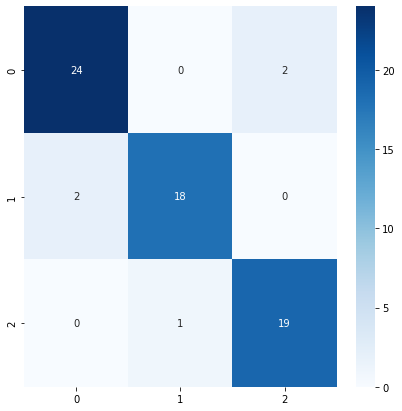

In [ ]:
SVM_cm = confusion_matrix(y_test, SVM_preds)
plt.figure(figsize = (7,7))
sns.heatmap(SVM_cm, annot=True, cmap='Blues')

In [ ]:
myLR = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=44)
rand_list = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

LR_search = RandomizedSearchCV(myLR, param_distributions = rand_list, n_iter = 10, cv = 3, verbose=3, random_state=44)

In [ ]:
LR_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ..C=3.3393685946625977, penalty=l1;, score=0.911 total time= 1.0min
[CV 2/3] END ..C=3.3393685946625977, penalty=l1;, score=0.928 total time=  53.4s
[CV 3/3] END ..C=3.3393685946625977, penalty=l1;, score=0.886 total time= 1.1min
[CV 1/3] END .C=0.12709920837403743, penalty=l1;, score=0.887 total time=  56.8s
[CV 2/3] END .C=0.12709920837403743, penalty=l1;, score=0.868 total time=  53.4s
[CV 3/3] END .C=0.12709920837403743, penalty=l1;, score=0.814 total time=  54.0s
[CV 1/3] END ..C=1.4420033450251428, penalty=l1;, score=0.893 total time= 1.0min
[CV 2/3] END ..C=1.4420033450251428, penalty=l1;, score=0.934 total time=  52.8s
[CV 3/3] END ..C=1.4420033450251428, penalty=l1;, score=0.892 total time= 1.0min
[CV 1/3] END ..C=1.1855037095915786, penalty=l2;, score=0.911 total time=  28.3s
[CV 2/3] END ..C=1.1855037095915786, penalty=l2;, score=0.934 total time=  27.3s
[CV 3/3] END ..C=1.1855037095915786, penalty=l2;

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=200, random_state=44,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc1cd56e990>,
                                        'penalty': ['l2', 'l1']},
                   random_state=44, verbose=3)

> ## Result shows that the best model found with the C value: 1.185, L2 Regularization with the accuracy: 0.90 which is considerebly good but not better than SVM.
> ## As it is shown in the table above the fiting process got around 28 seconds to run which is way slower than SVM.
> ## Other fiting times are also listed above as we can see L1 penalty is way more slower than others with around a minute.

In [ ]:
print(LR_search.best_params_)

{'C': 1.1855037095915786, 'penalty': 'l2'}


In [ ]:
LR_preds = LR_search.predict(X_test)

LR_accuracy = accuracy_score(y_test, LR_preds)
print("Best accuracy on Logistic Regression :", LR_accuracy)

Best accuracy on Logistic Regression : 0.8939393939393939


### Best found hyperparameters on Linear regression model Confusion matrix:

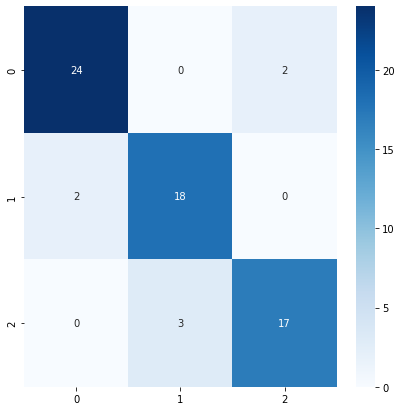

In [ ]:
LR_cm = confusion_matrix(y_test, LR_preds)
plt.figure(figsize = (7,7))
sns.heatmap(LR_cm, annot=True, cmap='Blues')

### 2) Using dimentionality reduction and see how the performance will change on our models.

### I used scikit learn pca module to try pca on our data.
### I chose 200 principle components and tested those two high accuracy models and found that there is no significant change happened in the result.

In [ ]:
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((502, 200), (66, 200))

In [ ]:
mySVM_pca = SVC(C=8.31521012310841, gamma=0.8986246602807306, kernel='poly', random_state=44)
mySVM_pca.fit(X_train_pca, y_train)

SVC(C=8.31521012310841, gamma=0.8986246602807306, kernel='poly',
    random_state=44)

In [ ]:
SVM_preds_pca = mySVM_pca.predict(X_test_pca)

SVM_accuracy_pca = accuracy_score(y_test, SVM_preds_pca)
print("Accuracy on same SVM :", SVM_accuracy_pca)

Accuracy on same SVM : 0.9242424242424242


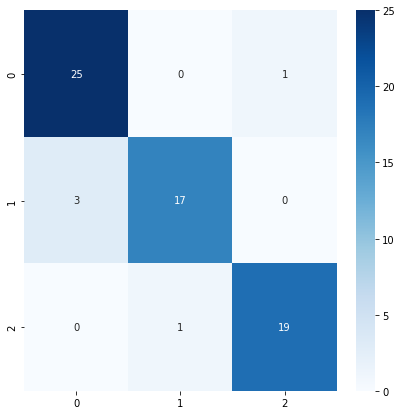

In [ ]:
SVM_cm_pca = confusion_matrix(y_test, SVM_preds_pca)
plt.figure(figsize = (7,7))
sns.heatmap(SVM_cm_pca, annot=True, cmap='Blues')

In [ ]:
myLR_pca = LogisticRegression(C=1.1855037095915786, penalty='l2', solver='saga', tol=1e-2, max_iter=200, random_state=44)
myLR_pca.fit(X_train_pca, y_train)

LogisticRegression(C=1.1855037095915786, max_iter=200, random_state=44,
                   solver='saga', tol=0.01)

In [ ]:
LR_preds_pca = myLR_pca.predict(X_test_pca)

LR_accuracy_pca = accuracy_score(y_test, LR_preds_pca)
print("Accuracy on same Logistic Regression :", LR_accuracy_pca)

Accuracy on same Logistic Regression : 0.9242424242424242


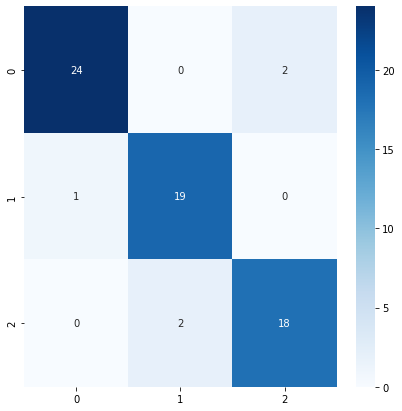

In [ ]:
LR_cm_pca = confusion_matrix(y_test, LR_preds_pca)
plt.figure(figsize = (7,7))
sns.heatmap(LR_cm_pca, annot=True, cmap='Blues')

---
### 3.
---

> #### I used transfer learning and fine tuning for this part.
> #### I Used VGG16 as base model, freeze all layers except last three conv layers, added classification layers.
> #### Fitted the data to train classification layers and fine tune those unfreezed layers.
> #### Got the result of **100%**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.device('/device:GPU:0')                                         # For using GPU on Colab

In [ ]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [ ]:
X_train = []
y_train = []

train_path = "/content/drive/MyDrive/Covid19-dataset/train/" # path containing training image samples

for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

X_train = np.append(X_train, X_aug, axis=0)
y_train = np.append(y_train, y_aug, axis=0)

In [ ]:
X_test = []
y_test = []

val_path = '/content/drive/MyDrive/Covid19-dataset/test/'

for folder in os.scandir(val_path):
    for entry in os.scandir(val_path + folder.name):

        X_test.append(read_and_preprocess(val_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='V':
            y_test.append(1)
        else:
            y_test.append(2)
            
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256,3)))

In [ ]:
basemodel.trainable = True

for layer in basemodel.layers[:-4]:
    layer.trainable = False

for i, layer in enumerate(basemodel.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001)
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="covid_classifier_weights.h5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_test, y_test), batch_size=16, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.8865
Epoch 00001: val_loss improved from inf to 0.08914, saving model to covid_classifier_weights.h5
32/32 [==============================] - 8s 226ms/step - loss: 0.2692 - accuracy: 0.8865 - val_loss: 0.0891 - val_accuracy: 0.9394
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9920
Epoch 00002: val_loss improved from 0.08914 to 0.03786, saving model to covid_classifier_weights.h5
32/32 [==============================] - 7s 216ms/step - loss: 0.0334 - accuracy: 0.9920 - val_loss: 0.0379 - val_accuracy: 1.0000
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.03786 to 0.01647, saving model to covid_classifier_weights.h5
32/32 [==============================] - 7s 228ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 4/50
32/32 [===========

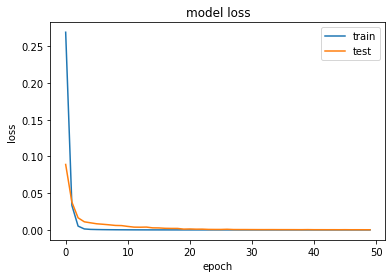

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

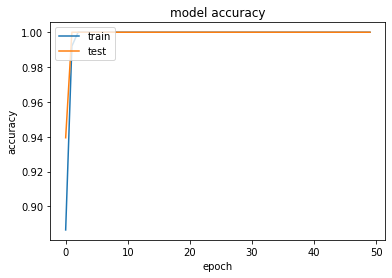

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Load pretrained model (best saved one)
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [ ]:
predictions = model.predict(X_test)
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
transfer_accuracy = accuracy_score(y_test, predict)
print("Transfered VGG16 with fine tuning on last block (3 conv layers) accuracy: ", transfer_accuracy)

Transfered VGG16 with fine tuning on last block (3 conv layers) accuracy:  1.0


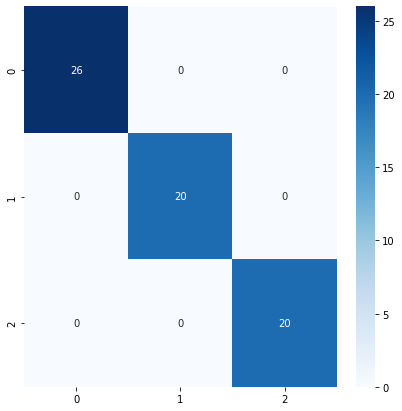

In [ ]:
transfer_cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(transfer_cm, annot=True, cmap='Blues')